In [1]:
# import nltk
# nltk.download('wordnet')
# nltk.download('stopwords')

In [2]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
# from nltk.tokenize import TweetTokenizer
from nltk.tokenize.casual import reduce_lengthening
# from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from math import ceil
from sklearn.metrics import (f1_score, classification_report, 
                            confusion_matrix, accuracy_score, 
                            precision_score, recall_score, 
                            roc_auc_score, roc_curve)
from sklearn.preprocessing import label_binarize
from scipy.spatial.distance import cosine
import string
from math import log10, sqrt, cos, pi
from scipy.stats import norm
import re
import pickle
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

## Importing Tweet Data
***

In [3]:
columns = ['tweet_id','timestamp','tweet_text','user_id',
           'tweet_coords','tweet_coords_list','tweet_long','tweet_lat','location',
           'enc_url','tweet_lang','hashtags']
tweet_full = pd.read_csv(r'./tweetCoords.csv',
                         header=None,
                         names=columns,
                         parse_dates=[1],
                         infer_datetime_format=True,
                         index_col='timestamp')

In [4]:
tweet_full.count()

tweet_id             784322
tweet_text           784322
user_id              784322
tweet_coords         335535
tweet_coords_list    784171
tweet_long           784322
tweet_lat            784322
location             784322
enc_url               71550
tweet_lang           784322
hashtags             205107
dtype: int64

In [98]:
tweet_full[(tweet_full.index >= '2017-09-10 00:00:00')&
           (tweet_full.index <= '2017-09-12 23:59:59')].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 54383 entries, 2017-09-10 00:00:01 to 2017-09-12 23:59:52
Data columns (total 11 columns):
tweet_id             54383 non-null int64
tweet_text           54383 non-null object
user_id              54383 non-null int64
tweet_coords         23157 non-null object
tweet_coords_list    54354 non-null object
tweet_long           54383 non-null float64
tweet_lat            54383 non-null float64
location             54383 non-null object
enc_url              5102 non-null object
tweet_lang           54383 non-null object
hashtags             15300 non-null object
dtypes: float64(2), int64(2), object(7)
memory usage: 5.0+ MB


In [97]:
len(tweet_full[(tweet_full.index >= '2017-09-10 00:00:00')&
               (tweet_full.index <= '2017-09-12 23:59:59')].user_id.unique())

16598

In [99]:
tweet_paper = tweet_full[(tweet_full.index >= '2017-09-10 00:00:00')&
           (tweet_full.index <= '2017-09-12 23:59:59')]

In [111]:
len(tweet_paper[tweet_paper.tweet_coords.isnull()])

31226

In [112]:
len(tweet_paper[tweet_paper.tweet_coords_list.isnull()])

29

In [108]:
len(tweet_paper[tweet_paper.tweet_long.isnull()])

0

In [118]:
tweet_paper[tweet_paper.tweet_coords.notnull()].head(1)

,tweet_id,tweet_text,user_id,tweet_coords,tweet_coords_list,tweet_long,tweet_lat,location,enc_url,tweet_lang,hashtags
timestamp,,,,,,,,,,,
2017-09-10 00:00:01,906668545542680576,"Wind 2.0 mph N. Barometer 29.880 in, Steady. Temperature 79.1 F. Rain today 0.95 in. Humidity 84",1227982520,"[28.87527778,-81.2525]","[[[-81.285896, 28.84511], [-81.285896, 28.964071], [-81.154121, 28.964071], [-81.154121, 28.84511]]]",-81.2525,28.8753,Deltona,NaN,en,NaN


In [110]:
print(tweet_paper.tweet_long.max())
print(tweet_paper.tweet_long.min())
print(tweet_paper.tweet_lat.max())
print(tweet_paper.tweet_lat.min())

-80.0327
-84.94
30.7113
24.4


In [5]:
tweet_full[tweet_full.enc_url.notnull()]

,tweet_id,tweet_text,user_id,tweet_coords,tweet_coords_list,tweet_long,tweet_lat,location,enc_url,tweet_lang,hashtags
timestamp,,,,,,,,,,,
2017-09-01 00:00:06,903407078823399424,First @TBBuccaneers with my bride @carrie_duna...,199257968,NaN,"[[[-82.503349, 27.975994], [-82.503349, 27.975...",-82.5033,27.9760,Raymond James Stadium,http://pbs.twimg.com/media/DImL102W0AApkbC.jpg,en,"lovetampa,bucs,buccaneers"
2017-09-01 00:00:34,903407194804289538,Severe Thunderstorm Warning including Monticel...,2544250500,"[30.4713994,-83.76763916]","[[[-87.634643, 24.396308], [-87.634643, 31.001...",-83.7676,30.4714,Florida,http://pbs.twimg.com/media/DImMDh3XoAACzd0.jpg,en,NaN
2017-09-01 00:00:36,903407203285172224,Severe Thunderstorm Warning including Monticel...,590286441,"[30.4713994,-83.76763916]","[[[-87.634643, 24.396308], [-87.634643, 31.001...",-83.7676,30.4714,Florida,http://pbs.twimg.com/media/DImMD-SXUAAnEVh.jpg,en,NaN
2017-09-01 00:01:38,903407462153416704,@TheLarryP heard it was your birthday http...,288575015,NaN,"[[[-80.147162, 25.761308], [-80.147162, 25.872...",-80.1330,25.8170,Miami Beach,http://pbs.twimg.com/tweet_video_thumb/DImMSaM...,en,NaN
2017-09-01 00:01:48,903407505539297280,https://t.co/Y22IRxobPG,4230773019,NaN,"[[[-82.505816, 27.209524], [-82.505816, 27.236...",-82.4910,27.2231,Vamo,http://pbs.twimg.com/media/DImMVHrXcAAYi9c.jpg,und,NaN
2017-09-01 00:01:50,903407514519293953,@edsheeran Concert https://t.co/D4yvDxbHDs,719067485471961089,NaN,"[[[-81.383715, 28.539743], [-81.383715, 28.539...",-81.3837,28.5397,Amway Center,http://pbs.twimg.com/media/DImMVe_UwAEMR5d.jpg,es,NaN
2017-09-01 00:03:07,903407838722183168,Had a great time at #GiffordMiddleSchool Open ...,1597212350,NaN,"[[[-80.413675, 27.675962], [-80.413675, 27.675...",-80.4137,27.6760,Gifford Middle School,http://pbs.twimg.com/media/DImMlhwXcAAzbBs.jpg,en,"GiffordMiddleSchool,OPENHOUSECHALLENGE"
2017-09-01 00:03:25,903407911443079168,It s goin down by the beach boi Nuff choons...,108394599,NaN,"[[[-80.127089, 25.799543], [-80.127089, 25.799...",-80.1271,25.7995,1 Hotel Homes South Beach,http://pbs.twimg.com/media/DImMtP6WsAAx2jb.jpg,en,"DJIRiE,1HotelSouthBeach,FunkShui"
2017-09-01 00:03:26,903407916933369856,#HonortheFallen #UCF https://t.co/SpYjTPCG9U,50300831,NaN,"[[[-81.192999, 28.607959], [-81.192999, 28.607...",-81.1930,28.6080,Bright House Networks Stadium,http://pbs.twimg.com/media/DImMtA2WAAEK0y7.jpg,und,"HonortheFallen,UCF"


In [6]:
related_words = pd.DataFrame()
tweet_date = pd.to_datetime("2017-09-10 00:00:00")
date_delta = pd.Timedelta("24HR")
end_date = pd.to_datetime("2017-09-10 00:00:00")

In [7]:
tweet_full_en = tweet_full[tweet_full['tweet_lang'] == 'en']

In [8]:
tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]

## Helper Functions
***

In [9]:
tweet_stops = stopwords.words('english')
stemmer = PorterStemmer()

def clean_tweet(tweet):
##     takes input string and converts or removes characters depending on settings.
##     returns a string
##     convert case:
    tweet = tweet.lower()
##    remove URLs:
    tweet = re.sub('https?://\S+','',tweet)
##     remove @mentions, including those with a leading '-' or '.' : 
    tweet = re.sub('[-\.]?@\w+','',tweet)
##     remove non-hashtag punctuation:
#     tweet = tweet.translate(tweet.maketrans('','',string.punctuation.replace("#","")))
##     convert non-hashtag punctuation to whitespace:
    tweet = tweet.translate(tweet.maketrans(string.punctuation.replace("#","")," "*len(string.punctuation.replace("#",""))))
#     remove non-hashtag '#'.
    tweet = re.sub('\B#\B','',tweet)
##     remove 'amp', 'gt', 'lt', indicating decoded ampersand, greater-than, less-than characters
    tweet = re.sub(r'\b(amp|gt|lt)\b','',tweet)
##     drop numbers and words of < 4 characters.
#     tweet = re.sub(r'\b(?<!#)\w{1,3}\b','',tweet)
    tweet = re.sub(r'\b(?<!#)\d+\b','',tweet)
    return tweet

def tokens_no_stopwords(tweet_as_string):
#     wrapper function that combines the tokenizer, cleaner, and stopword removal.
#     takes a string and returns a list of strings
    cleaned_tweet = clean_tweet(tweet_as_string)
    tweet_reduce_len = reduce_lengthening(cleaned_tweet)
#     tweet_as_tokens = word_tokenize(tweet_reduce_len)
    tweet_as_tokens = tweet_reduce_len.split()
    tweet_no_stops = [stemmer.stem(word) for word in tweet_as_tokens if word not in tweet_stops]
    
    return tweet_no_stops

## Miscellaneous Tests:
***

In [10]:
punc_test = "This is some (&) text$that has &*char$ in it"
punc_test.translate(punc_test.maketrans(string.punctuation.replace("#","")," "*len(string.punctuation.replace("#",""))))

'This is some     text that has   char  in it'

In [11]:
punc_test.translate(punc_test.maketrans('','',string.punctuation.replace("#","")))

'This is some  textthat has char in it'

In [12]:
# tweet_tokenizer = TweetTokenizer(strip_handles=True,preserve_case=False,reduce_len=True)

In [13]:
re_hash_test = '# #34 4#3 A#36 3 A# #hashtag'
print(re.sub(r'\b#\B','!',re_hash_test))
print(re.sub(r'\b#\b','!',re_hash_test))
print(re.sub(r'\B#\B','!',re_hash_test))

# #34 4#3 A#36 3 A! #hashtag
# #34 4!3 A!36 3 A# #hashtag
! #34 4#3 A#36 3 A# #hashtag


In [14]:
text="this is a tweet # #### ####1 #hashtag #123 #12345 apm yooooo"
tokens_no_stopwords(text)

['tweet', '#1', '#hashtag', '#123', '#12345', 'apm', 'yooo']

## Word/Token Statistics
***

In [15]:
word_counts = tweet_text.str.split("\s+").apply(pd.Series).stack().value_counts()

In [16]:
word_counts.size

43387

In [17]:
word_counts.head(20)

the        4900
I          4133
to         3853
@          3337
a          3020
in         2998
and        2843
of         2796
is         2619
           2463
for        1977
my         1943
s          1772
you        1647
Florida    1592
this       1572
on         1491
t          1357
from       1236
it         1202
dtype: int64

In [18]:
word_counts.tail(20)

https://t.co/KQp7qk1YRX    1
https://t.co/TvBV4lRtsR    1
https://t.co/8ShMTBfmUy    1
https://t.co/wD9s3dRzHp    1
https://t.co/CEY2glSRHQ    1
#whileyouweresleeping      1
https://t.co/7WHufWMYgn    1
Probs                      1
east-northeast             1
@NBCPolitics               1
seen...                    1
glowing                    1
https://t.co/8umU3ZGttm    1
#update:                   1
#FreeJackboy               1
ouch                       1
https://t.co/VE7jXbBAlt    1
strive                     1
https://t.co/oeAIRRyddJ    1
@amorokarina               1
dtype: int64

In [19]:
# tweet_reduce_len = TweetTokenizer(reduce_len=True)
word_counts_reduce = tweet_text.apply(reduce_lengthening).str.split().apply(pd.Series).stack().value_counts()

In [20]:
word_counts_reduce.size

43254

In [21]:
# np.setdiff1d(word_counts.index.values,word_counts_reduce.index.values)

In [22]:
word_counts_reduce.head(20)

the        4900
I          4133
to         3853
@          3337
a          3020
in         2998
and        2843
of         2796
is         2619
for        1977
my         1943
s          1772
you        1647
Florida    1592
this       1572
on         1491
t          1357
from       1236
it         1202
at         1129
dtype: int64

In [23]:
# word_counts_full_tokenizer = tweet_text.apply(tweet_tokenizer.tokenize).apply(pd.Series).stack().value_counts()

In [24]:
# word_counts_full_tokenizer.size

In [25]:
# word_counts_full_tokenizer.head(20)

In [26]:
tokenized_tweets = tweet_text.apply(tokens_no_stopwords)

In [27]:
ex_text = "OOOOMMMMGGGGG This is the #1 worst THING HAPPENING IN 2017!!!!!! Power is out & Basement is flooded! #irma #hurricane @TV9 @my_friend https;//my.domain.net"

In [28]:
tweet_test = ex_text
print(tweet_test)
tweet_test = tweet_test.lower()
# print(word_tokenize(tweet_test))
print(tweet_test.split())
i=0
print(f"S: {tweet_test}");i+=1
#     1: remove URLs:
tweet_test = re.sub('https?://\S+','',tweet_test)
print(f"{i}: {tweet_test}");i+=1
#     2: remove @mentions, including those with a leading '-' or '.' : 
tweet_test = re.sub('[-\.]?@\w+','',tweet_test)
print(f"{i}: {tweet_test}");i+=1
#     3: remove punctuation, but not hashtags:
tweet_test = tweet_test.translate(tweet_test.maketrans('','',string.punctuation.replace("#","")))
print(f"{i}: {tweet_test}");i+=1
#     4: remove non-hashtag '#'.
# tweet_test = re.sub('#\B','',tweet_test)
print(f"{i}: {tweet_test}");i+=1
#     5: remove 'amp', 'gt', 'lt', indicating decoded ampersand, greater-than, less-than characters
# tweet_test = re.sub(r'\b(amp|gt|lt)\b','',tweet_test)
print(f"{i}: {tweet_test}");i+=1
#     6: drop words of < 4 characters, but not hashtags
tweet_test = re.sub(r'\b(?<!#)\w{1,3}\b','',tweet_test)
print(f"{i}: {tweet_test}");i+=1
#     7: drop numbers, but not hashtags
tweet_test = re.sub(r'\b(?<!#)\d+\b','',tweet_test)
print(f"{i}: {tweet_test}");i+=1

# print(word_tokenize(tweet_test))
# print(tokens_no_stopwords(tweet_test))

OOOOMMMMGGGGG This is the #1 worst THING HAPPENING IN 2017!!!!!! Power is out & Basement is flooded! #irma #hurricane @TV9 @my_friend https;//my.domain.net
['oooommmmggggg', 'this', 'is', 'the', '#1', 'worst', 'thing', 'happening', 'in', '2017!!!!!!', 'power', 'is', 'out', '&', 'basement', 'is', 'flooded!', '#irma', '#hurricane', '@tv9', '@my_friend', 'https;//my.domain.net']
S: oooommmmggggg this is the #1 worst thing happening in 2017!!!!!! power is out & basement is flooded! #irma #hurricane @tv9 @my_friend https;//my.domain.net
1: oooommmmggggg this is the #1 worst thing happening in 2017!!!!!! power is out & basement is flooded! #irma #hurricane @tv9 @my_friend https;//my.domain.net
2: oooommmmggggg this is the #1 worst thing happening in 2017!!!!!! power is out & basement is flooded! #irma #hurricane   https;//my.domain.net
3: oooommmmggggg this is the #1 worst thing happening in 2017 power is out  basement is flooded #irma #hurricane   httpsmydomainnet
4: oooommmmggggg this is t

In [29]:
pd.set_option('display.max_colwidth', -1)

In [30]:
print(reduce_lengthening(ex_text))

OOOMMMGGG This is the #1 worst THING HAPPENING IN 2017!!! Power is out & Basement is flooded! #irma #hurricane @TV9 @my_friend https;//my.domain.net


In [31]:
print(tokens_no_stopwords(ex_text))

['ooommmggg', '#1', 'worst', 'thing', 'happen', 'power', 'basement', 'flood', '#irma', '#hurrican', 'http', 'domain', 'net']


In [32]:
date_test = '2017-09-10 00:03:40'
print(tweet_text.loc[date_test].apply(reduce_lengthening))
print(tweet_text.loc[date_test].apply(tokens_no_stopwords))

timestamp
2017-09-10 00:03:40    #NaturalRemedies This Is the Only Product That Kills Viruses, Fungal Infections,... https://t.co/XUXtJZ5cBY  https://t.co/G05XM19Deg
2017-09-10 00:03:40    TAGGED 2017  #1 @ US 1-Biscayne Blvd. https://t.co/1foe57DVyC                                                                       
Name: tweet_text, dtype: object
timestamp
2017-09-10 00:03:40    [#naturalremedi, product, kill, virus, fungal, infect]
2017-09-10 00:03:40    [tag, #1, us, biscayn, blvd]                          
Name: tweet_text, dtype: object


In [33]:
tokenized_tweets[tokenized_tweets.apply(lambda x: '@' in x)]

Series([], Name: tweet_text, dtype: object)

In [34]:
word_counts_full_token_clean = tweet_text.apply(tokens_no_stopwords).apply(pd.Series).stack().value_counts()

In [35]:
word_counts_full_token_clean.size

14439

In [36]:
word_counts_full_token_clean.head(20)

florida           1809
#hurricaneirma    1623
fl                1587
irma              1374
hurrican          1360
#irma             1193
wind              946 
get               936 
report            886 
go                830 
storm             775 
power             715 
miami             705 
rain              682 
mph               661 
like              657 
beach             656 
gust              655 
safe              633 
aso               544 
dtype: int64

In [37]:
word_counts_full_token_clean.tail(20)

condition     1
gollaway      1
#campout      1
revolut       1
daybr         1
vfreid        1
japan         1
exec          1
ainnn         1
agholor       1
tradeoff      1
barrysand     1
flax          1
contest       1
quinci        1
#terravita    1
adriona       1
mutant        1
degrom        1
scarier       1
dtype: int64

In [38]:
tweet_len = tweet_text.groupby(tweet_text.str.split().apply(len)).size()

In [39]:
tweet_len_post = tweet_text.apply(tokens_no_stopwords).apply(len).value_counts().sort_index()

In [40]:
tweet_len_post[tweet_len_post.index <= 10].sum()

15971

In [41]:
tweet_len_post.sum()

19089

In [42]:
tweet_len

tweet_text
1     37  
2     342 
3     622 
4     753 
5     815 
6     911 
7     956 
8     1052
9     1121
10    1022
11    1020
12    1040
13    988 
14    1005
15    1308
16    1112
17    876 
18    862 
19    736 
20    587 
21    493 
22    349 
23    317 
24    239 
25    151 
26    163 
27    70  
28    68  
29    33  
30    21  
31    12  
32    6   
33    2   
Name: tweet_text, dtype: int64

In [43]:
tweet_len_post

0     91  
1     874 
2     1402
3     1565
4     1745
5     1854
6     1800
7     1812
8     1865
9     1684
10    1279
11    1278
12    870 
13    526 
14    206 
15    117 
16    73  
17    26  
18    14  
19    6   
20    2   
Name: tweet_text, dtype: int64

In [44]:
tweet_len_post[tweet_len_post.index < 11].sum()

15971

In [45]:
# tweet_len_post[tweet_len_post.index < 11].sum()/tweet_len_post.sum()

In [46]:
plt.style.use('bmh')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

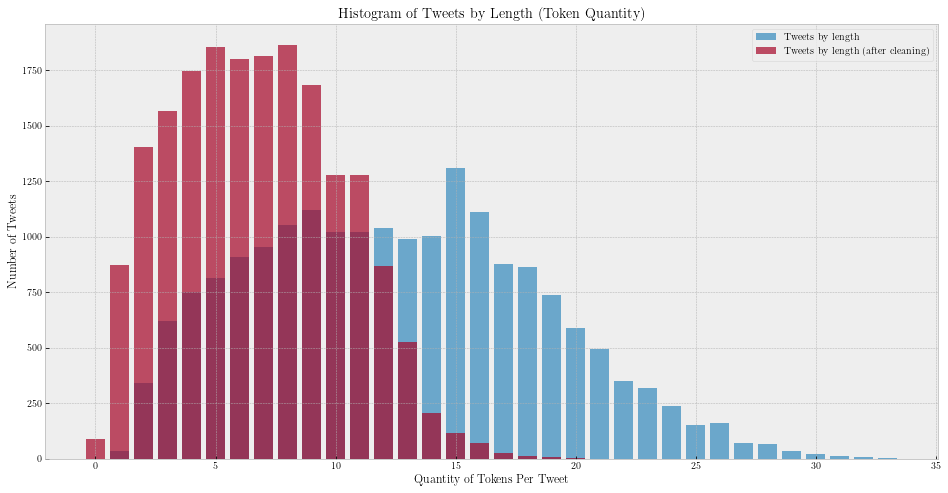

In [47]:
fig_tweet_hist = plt.figure(figsize=(16,8))
plt.bar(tweet_len.index,tweet_len.values,alpha=.7,label="Tweets by length")
plt.bar(tweet_len_post.index,tweet_len_post.values,alpha=.7,label="Tweets by length (after cleaning)")
plt.xlabel("Quantity of Tokens Per Tweet")
plt.ylabel("Number of Tweets")
plt.title("Histogram of Tweets by Length (Token Quantity)")
plt.legend()
plt.show()
#fig_tweet_hist.savefig(f'./figures/TweetsByLength.pdf',bbox_inches='tight')

## Skip-Gram

### Search Term

In [48]:
search_term = 'irma'

### Window Size: 1-10

In [49]:
# # comparison_type = "Min. Word Freq."
# # comparison_short = "MinWordFreq"
# comparison_type = "Window Size"
# comparison_short = "WindowSize"

In [50]:
# # eliminating the off-by-one error in the loop later. This will have a zero row, unfilled by vectors.
# vectors_series = pd.Series(np.zeros((12)))

In [51]:
# tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
# tweets_tokens = tweet_text.apply(tokens_no_stopwords)
# for i in range(0,11):
#     # ---------- Skip-Gram ----------
#     # initialize the Word2Vec vectors with window size i, min count 1, and Skip-Gram
#     vector_model = Word2Vec(tweets_tokens, seed=1, sg=1, min_count=i)#, window=8, workers=1, size=100, negative=i)
    
#     # train the model over 10 epochs
#     vector_model.train(tweets_tokens, total_examples=len(tweet_text), epochs=10)
    
#     # assign the vector data to its position in a series
#     vectors_series.iloc[i] = vector_model

In [52]:
coded_tweets = pd.read_csv(r'./irma_related_tweets.csv')

tweets_on_date = tweet_full_en.loc[tweet_date:tweet_date+date_delta]

tweet_encoded = pd.concat([coded_tweets.reset_index(),tweets_on_date.iloc[:-1].reset_index()],axis=1)

### Comparison Functions

Need a way to write the comparison functions with a larger function that calls them.

how about writing the functions as separate, with a larger function that calls the smaller functions with an argument.

- Mean Cosine Similarity
- Sum Cosine Similarity Over Square Root of Length
- Dot Product of Tweet As Matrix Sum of Term Vectors and Search Term
- Cosine Similarity of Tweet As Matrix Sum of Term Vectors and Search Term

In [53]:
def meanCosSim(tweet,vector_set):
    tweet_as_terms = tokens_no_stopwords(tweet)
    score = 0
    for i in tweet_as_terms:
        if i in vector_set.wv.vocab:
            score += vector_set.wv.similarity(i,search_term)
    if len(tweet_as_terms) > 0:
        score /= len(tweet_as_terms)
    else:
        score = 0
    return score

In [54]:
def sumCosSimSqrtSum(tweet,vector_set):
    tweet_as_terms = tokens_no_stopwords(tweet)
    score = 0
    for i in tweet_as_terms:
        if i in vector_set.wv.vocab:
            score += vector_set.wv.similarity(i,search_term)
    if len(tweet_as_terms) > 0:
        score /= sqrt(len(tweet_as_terms))
    else:
        score = 0
    return score

In [55]:
def dotProductOfTweetMatrixTermVector(tweet,vector_set):
    tweet_as_terms = tokens_no_stopwords(tweet)
#     initialize vector with dimensionality of the vector set.
    vector_dim = len(vector_set.wv.vectors[0])
    score_matrix = np.zeros(vector_dim,) 
#     iterate over each word after processing. If the word is in the vocabulary,
#     add its vector's value to the score matrix.
#     this essentially treats a word not in the vocabulary as a zero-vector.
    for i in tweet_as_terms:
        if i in vector_set.wv.vocab:
            score_matrix = np.add(score_matrix,vector_set.wv.get_vector(i))
#     if the number of words remaining in the tweet after processing is equal to zero, return zero.
#     otherwise, take the dot product of the score vector, and the vector of the search term.
    if len(tweet_as_terms) > 0:
        score = np.dot(score_matrix,vector_set.wv.get_vector(search_term))
    else:
        score = 0
    return score

In [56]:
def cosSimOfTweetMatrixTermVector(tweet,vector_set):
    tweet_as_terms = tokens_no_stopwords(tweet)
#     initialize vector with dimensionality of the vector set.
    vector_dim = len(vector_set.wv.vectors[0])
    score_matrix = np.zeros(vector_dim,) 
#     iterate over each word after processing. If the word is in the vocabulary,
#     add its vector's value to the score matrix.
#     this essentially treats a word not in the vocabulary as a zero-vector.
    for i in tweet_as_terms:
        if i in vector_set.wv.vocab:
            score_matrix = np.add(score_matrix,vector_set.wv.get_vector(i))
#     if the number of words remaining in the tweet after processing is equal to zero, return zero.
#     otherwise, take the pairwise cosine of the score vector and the vector of the search term.
    if ((len(tweet_as_terms) > 0) & (np.all(score_matrix != np.zeros(vector_dim,)))):
        score = 1 - cosine(score_matrix,vector_set.wv.get_vector(search_term))
    else:
        score = 0
    return score

Wrapper Function for the scalar comparison formulas:

In [57]:
def scalarFunctions(tweet,vector_set,formula='dp'):
    if(formula.upper() == 'DP'):
        return dotProductOfTweetMatrixTermVector(tweet,vector_set)
    elif(formula.upper() == 'MCS'):
        return meanCosSim(tweet,vector_set)
    elif(formula.upper() == 'SCSSC'):
        return sumCosSimSqrtSum(tweet,vector_set)
    elif(formula.upper() == 'CSTVS'):
        return cosSimOfTweetMatrixTermVector(tweet,vector_set)
    else:
        return np.NaN

In [58]:
# scalarFunctions(tweets_on_date.iloc[0,1],vectors_series[1],'mcs')

In [59]:
# func_type = "Mean Cosine Similarity"
# func_short = "MeanCosSim"
# def ScoreTweetFromVectors(tweet,vector_set):
#     tweet_as_terms = tokens_no_stopwords(tweet)
#     score = 0
#     for i in tweet_as_terms:
#         if i in vector_set.wv.vocab:
#             score += vector_set.wv.similarity(i,search_term)
#     if len(tweet_as_terms) > 0:
#         score /= len(tweet_as_terms)
#     else:
#         score = 0
#     return score

In [60]:
# from math import sqrt
# func_type = "Sum Score over Sqrt Cos. Sim."
# func_short = "SumOverSqrtLen"
# def ScoreTweetFromVectors(tweet,vector_set):
#     tweet_as_terms = tokens_no_stopwords(tweet)
#     score = 0
#     for i in tweet_as_terms:
#         if i in vector_set.wv.vocab:
#             score += vector_set.wv.similarity(i,search_term)
#     if len(tweet_as_terms) > 0:
#         score /= sqrt(len(tweet_as_terms))
#     else:
#         score = 0
#     return score

In [61]:
# func_type = "Dot Product of Tweet Vector and Search Term"
# func_short = "DotProduct"
# def ScoreTweetFromVectors(tweet,vector_set):
#     tweet_as_terms = tokens_no_stopwords(tweet)
# #     initialize vector with dimensionality of the vector set.
#     vector_dim = len(vector_set.wv.vectors[0])
#     score_matrix = np.zeros(vector_dim,) 
# #     iterate over each word after processing. If the word is in the vocabulary,
# #     add its vector's value to the score matrix.
# #     this essentially treats a word not in the vocabulary as a zero-vector.
#     for i in tweet_as_terms:
#         if i in vector_set.wv.vocab:
#             score_matrix = np.add(score_matrix,vector_set.wv.get_vector(i))
# #     if the number of words remaining in the tweet after processing is equal to zero, return zero.
# #     otherwise, take the dot product of the score vector, and the vector of the search term.
#     if len(tweet_as_terms) > 0:
#         score = np.dot(score_matrix,vector_set.wv.get_vector(search_term))
#     else:
#         score = 0
#     return score

In [62]:
# func_type = "Cosine Similarity of Tweet Vector Sum and Search Term"
# func_short = "CosSimTweetVecSum"
# def ScoreTweetFromVectorsCSTVS(tweet,vector_set):
#     tweet_as_terms = tokens_no_stopwords(tweet)
# #     initialize vector with dimensionality of the vector set.
#     vector_dim = len(vector_set.wv.vectors[0])
#     score_matrix = np.zeros(vector_dim,) 
# #     iterate over each word after processing. If the word is in the vocabulary,
# #     add its vector's value to the score matrix.
# #     this essentially treats a word not in the vocabulary as a zero-vector.
#     for i in tweet_as_terms:
#         if i in vector_set.wv.vocab:
#             score_matrix = np.add(score_matrix,vector_set.wv.get_vector(i))
# #     if the number of words remaining in the tweet after processing is equal to zero, return zero.
# #     otherwise, take the pairwise cosine of the score vector and the vector of the search term.
#     if len(tweet_as_terms) > 0:
#         score = 1 - cosine(score_matrix,vector_set.wv.get_vector(search_term))
#     else:
#         score = 0
#     return score

In [63]:
# tweet_encoded.iloc[0:5].tweet_text.apply(scalarFunctions,args=(vectors_series.iloc[1],'mcs'))

In [64]:
# for i in range(0,11):
# #     create strings for column heads
#     sw = f'score_window_{i}'
#     mmsw = f'MM_{sw}'
    
# #     Scoring tweets in this column:
#     tweet_encoded[sw] = tweet_encoded.tweet_text.apply(scalarFunctions,args=(vectors_series.iloc[i],'dp'))
                                                       
# #     column of scores for this iteration
#     tweet_scores = tweet_encoded[sw]

# #     calculating Min Max Scaling for this column 
#     tweet_encoded[mmsw] = ((tweet_scores - tweet_scores.min())* 100) / (tweet_scores.max() - tweet_scores.min())

In [65]:
# vectors_series.iloc[1].wv.similar_by_word("irma", topn=10, restrict_vocab=None)

In [66]:
# for i in range(0,11):
#     print(round(roc_auc_score(tweet_encoded['irma_rel'],tweet_encoded[f'MM_score_window_{i}']),5))

In [67]:
# fig_0 = plt.figure(figsize=(16,8),facecolor='w')

# for j in range(1,11):
#     window_label = f"{comparison_type}: {j}"
#     plt.plot(range(101),[100*len(tweet_encoded[tweet_encoded[f'MM_score_window_{j}'] > i])/len(tweet_encoded) for i in range(101)],label=window_label)
# plt.xlabel("Min-Max Scaled Tweet Score Threshold")
# plt.ylabel("Percent of Tweets at or above Threshold")
# plt.title(f"Percent of Tweets at or above Threshold by Word2Vec {comparison_type} ({func_type})")
# plt.legend();

# fig_0.savefig(f'./figures/{comparison_short}{func_short}PercentTweetsBelow.pdf',bbox_inches='tight')

### F1 Score Comparisons

In [68]:
# f1_window_score_df = pd.DataFrame(np.zeros((101,11)))
# pre_score_df = pd.DataFrame(np.zeros((101,11)))
# rec_score_df = pd.DataFrame(np.zeros((101,11)))

In [69]:
# for i in range(1,11):
#     for j in range(101):
#         f1_window_score_df.iloc[j,i] = f1_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)
#         pre_score_df.iloc[j,i] = precision_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)
#         rec_score_df.iloc[j,i] = recall_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)

In [70]:
# print(pd.concat([f1_window_score_df.idxmax(),f1_window_score_df.max()],axis=1,names=['TweetScore','F1Score']))
# print(f1_window_score_df.idxmax().max())
# print(f1_window_score_df.max().max())

In [71]:
# fig_1 = plt.figure(figsize=(16,8),facecolor='w')
# for i in range(1,11):
#     plt.plot(f1_window_score_df.iloc[:,i],label=f"{comparison_type}: {i}")
# plt.xlabel("Min-Max Scaled Tweet Score Threshold")
# plt.ylabel("F1 Score of Tweets Above Threshold")
# plt.title(f"F1 Score of Tweets by Word2Vec {comparison_type} ({func_type})")
# plt.legend();
# # fig_1.savefig(f'./figures/{comparison_short}{func_short}F1Score.pdf',bbox_inches='tight')

### Hidden Layer Dimensionality (window size 7)

In [72]:
# comparison_type = "Hidden Layer Dimensionality"
# comparison_short = "HLD"

In [73]:
# # eliminating the off-by-one error in the loop later. This will have a zero row, unfilled by vectors.
# vectors_series = pd.Series(np.zeros((11)))

In [74]:
# %%timeit
# tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
# tweets_tokens = tweet_text.apply(tokens_no_stopwords)
# for i in range(1,11):
#     hidden_layer_dim = 50*i
#     # ---------- Skip-Gram ----------
#     # initialize the Word2Vec vectors with window size 8, min count 1, and Skip-Gram (Hidden Layer Dim. Test)
#     vector_model = Word2Vec(tweets_tokens, min_count=1, window=8, workers=1, size=hidden_layer_dim, seed=1, sg=1, negative=5)
    
#     # train the model over 10 epochs
#     vector_model.train(tweets_tokens, total_examples=len(tweet_text), epochs=10)
    
#     # assign the vector data to its position in a series
#     vectors_series.iloc[i] = vector_model

## 2min 29s ± 544 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [75]:
# %%timeit
# tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
# tweets_tokens = tweet_text.apply(tokens_no_stopwords)

# opt_vector_model = Word2Vec(tweets_tokens, min_count=1, window=8, workers=1, size=150, seed=1, sg=1, negative=1)
    
# # train the model over 10 epochs
# opt_vector_model.train(tweets_tokens, total_examples=len(tweet_text), epochs=10)
## 6.67 s ± 42.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [76]:
# %%timeit
# tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
# tweets_tokens = tweet_text.apply(tokens_no_stopwords)

# opt_vector_model = Word2Vec(tweets_tokens, min_count=1, window=8, workers=1, size=150, seed=1, sg=1, negative=1)
    
# # train the model over 10 epochs
# opt_vector_model.train(tweets_tokens, total_examples=len(tweet_text), epochs=50)
## 16.1 s ± 122 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [77]:
# taking values from iterative test
HD=150
MWC=5
WWS=1
NS=1
EP=25
tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
tweets_tokens = tweet_text.apply(tokens_no_stopwords)

opt_vector_model = Word2Vec(tweets_tokens, min_count=MWC, window=WWS, workers=1, size=HD, seed=1, sg=1, negative=NS)
    
# train the model over 10 epochs
opt_vector_model.train(tweets_tokens, total_examples=len(tweet_text), epochs=EP)

(2482287, 3224100)

In [78]:
mt3_tweet = "check out what the storm did last night!"
scalarFunctions(mt3_tweet,opt_vector_model,'dp')

7.244507413962588

In [79]:
# opt_vector_model.wv.get_vector('irma')

In [80]:
tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
tweets_tokens = tweet_text.apply(tokens_no_stopwords)

def_vector_model = Word2Vec(tweets_tokens, seed=1, sg=1)
    
# train the model over 10 epochs
#def_vector_model.train(tweets_tokens, total_examples=len(tweet_text), epochs=10)

### AU-ROC Score

In [81]:
# default parameters for Word2Vec:
for i in ['dp','mcs','scssc','cstvs']:
#     create strings for column heads
    sw = f'd-sw-{i}'
    mmsw = f'MM-{sw}'
    
#     Scoring tweets in this column:
    tweet_encoded[sw] = tweet_encoded.tweet_text.apply(scalarFunctions,args=(def_vector_model,i))
                                                       
#     column of scores for this iteration|
    tweet_scores = tweet_encoded[sw]

#     calculating Min Max Scaling for this column 
    tweet_encoded[mmsw] = ((tweet_scores - tweet_scores.min())* 100) / (tweet_scores.max() - tweet_scores.min())

In [82]:
# Optimal parameters for Word2Vec:
for i in ['dp','mcs','scssc','cstvs']:
#     create strings for column heads
    sw = f'o-sw-{i}'
    mmsw = f'MM-{sw}'
    
#     Scoring tweets in this column:
    tweet_encoded[sw] = tweet_encoded.tweet_text.apply(scalarFunctions,args=(opt_vector_model,i))
                                                       
#     column of scores for this iteration|
    tweet_scores = tweet_encoded[sw]

#     calculating Min Max Scaling for this column 
    tweet_encoded[mmsw] = ((tweet_scores - tweet_scores.min())* 100) / (tweet_scores.max() - tweet_scores.min())

In [83]:
tweet_encoded.columns

Index(['index', 'irma_rel', 'tweet', 'timestamp', 'tweet_id', 'tweet_text',
       'user_id', 'tweet_coords', 'tweet_coords_list', 'tweet_long',
       'tweet_lat', 'location', 'enc_url', 'tweet_lang', 'hashtags', 'd-sw-dp',
       'MM-d-sw-dp', 'd-sw-mcs', 'MM-d-sw-mcs', 'd-sw-scssc', 'MM-d-sw-scssc',
       'd-sw-cstvs', 'MM-d-sw-cstvs', 'o-sw-dp', 'MM-o-sw-dp', 'o-sw-mcs',
       'MM-o-sw-mcs', 'o-sw-scssc', 'MM-o-sw-scssc', 'o-sw-cstvs',
       'MM-o-sw-cstvs'],
      dtype='object')

In [84]:
opt_vector_model.wv.similarity('irma','storm')

0.36600184

In [85]:
tweet_encoded[(tweet_encoded['o-sw-dp']>7.72) & (tweet_encoded['o-sw-dp']<7.73)]

,index,irma_rel,tweet,timestamp,tweet_id,tweet_text,user_id,tweet_coords,tweet_coords_list,tweet_long,...,d-sw-cstvs,MM-d-sw-cstvs,o-sw-dp,MM-o-sw-dp,o-sw-mcs,MM-o-sw-mcs,o-sw-scssc,MM-o-sw-scssc,o-sw-cstvs,MM-o-sw-cstvs
142,142,1,First world problems. #HurricaneIrma https://t.co/je4ItB7mck,2017-09-10 00:06:35,906670199402790914,First world problems. #HurricaneIrma https://t.co/je4ItB7mck,312295597,"[28.00435436,-82.45708083]","[[[-82.620093, 27.821353], [-82.620093, 28.171836], [-82.265295, 28.171836], [-82.265295, 27.821353]]]",-82.4571,...,0.727983,72.798321,7.723885,21.184085,0.211452,33.723446,0.422905,38.302004,0.358319,48.842400
361,361,1,Thank You to all our hard working men and women in the @PBCFR Communications Center answering 911 calls https://t.co/yzKcshifwF,2017-09-10 00:18:00,906673072396173312,Thank You to all our hard working men and women in the @PBCFR Communications Center answering 911 calls https://t.co/yzKcshifwF,249692222,NaN,"[[[-80.257234, 26.665515], [-80.257234, 26.736442], [-80.156201, 26.736442], [-80.156201, 26.665515]]]",-80.2067,...,0.786648,78.664761,7.720120,21.177072,0.138613,27.601406,0.415840,37.924629,0.237972,39.247809
525,525,0,It better break up. This is a couple of blocks from my house https://t.co/03WyoD0RlA,2017-09-10 00:26:00,906675085892780032,It better break up. This is a couple of blocks from my house https://t.co/03WyoD0RlA,311881803,NaN,"[[[-80.208086, 26.033366], [-80.208086, 26.091444], [-80.127345, 26.091444], [-80.127345, 26.033366]]]",-80.1677,...,0.813534,81.353450,7.721917,21.180419,0.228304,35.139793,0.510503,42.981159,0.335089,46.990389
820,820,1,WOW @nbc6 Meteorologist John Morales calls out irresponsible @Y100MIAMI amp @WIOD amp says Fuck em off camera. Wai https://t.co/D7FAeSy8EX,2017-09-10 00:40:54,906678835399282689,WOW @nbc6 Meteorologist John Morales calls out irresponsible @Y100MIAMI amp @WIOD amp says Fuck em off camera. Wai https://t.co/D7FAeSy8EX,16985324,NaN,"[[[-80.352067, 25.923399], [-80.352067, 25.957164], [-80.293194, 25.957164], [-80.293194, 25.923399]]]",-80.3226,...,0.704323,70.432323,7.720879,21.178485,0.102628,24.576922,0.340380,33.893861,0.239197,39.345448
1076,1076,0,We know we will miss the old Studios... but we are trying to do our best to trust in the Disney https://t.co/uEiZF6C7BQ,2017-09-10 00:52:03,906681643943034885,We know we will miss the old Studios... but we are trying to do our best to trust in the Disney https://t.co/uEiZF6C7BQ,4838107212,"[28.356126,-81.5602796]","[[[-87.634643, 24.396308], [-87.634643, 31.001056], [-79.974307, 31.001056], [-79.974307, 24.396308]]]",-81.5603,...,0.697761,69.776139,7.720588,21.177944,0.109487,25.153394,0.309677,32.253804,0.187802,35.248055
2631,2631,0,// Thinking nonstop about FL today. The faces of the locals that I https://t.co/ijeOcrW9Sl,2017-09-10 02:17:15,906703084964995074,// Thinking nonstop about FL today. The faces of the locals that I https://t.co/ijeOcrW9Sl,426159089,"[28.13333333,-81.63166667]","[[[-81.666836, 28.072873], [-81.666836, 28.143168], [-81.584261, 28.143168], [-81.584261, 28.072873]]]",-81.6317,...,0.792007,79.200693,7.727502,21.190821,0.230152,35.295164,0.563756,45.825733,0.292910,43.627702
5137,5137,0,Why the FUCK does Janet look like she s 27 this lady is iconic in so many different ways https://t.co/cfwV4Yt3A0,2017-09-10 05:39:38,906754014280388608,Why the FUCK does Janet look like she s 27 this lady is iconic in so many different ways https://t.co/cfwV4Yt3A0,2873496183,NaN,"[[[-80.244338, 26.195412], [-80.244338, 26.230126], [-80.195484, 26.230126], [-80.195484, 26.195412]]]",-80.2199,...,0.753996,75.399609,7.728009,21.191766,0.108417,25.063410,0.325250,33.085662,0.214173,37.350471
17803,17803,1,#hurricaneirma update from Orlando #houseofricards @ Reunion Resort- Luxury Villa Golf amp Spa Resort https://t.co/AFCfv62C3X,2017-09-10 22:51:45,907013756760113152,#hurricaneirma update from Orlando #houseofricards @ Reunion Resort- Luxury Villa Golf amp Spa Resort https://t.co/

In [86]:
# tweet_encoded[['tweet_id','timestamp','irma_rel','tweet','sw_dp','MM_sw_dp']].to_csv(r'./190930_wordScores.csv')

In [87]:
print(tweet_encoded['MM-o-sw-dp'].mean())
print(tweet_encoded['MM-o-sw-dp'].median())
print(tweet_encoded['MM-o-sw-dp'].std())

24.73268412767306
21.647652860849547
14.059388600824995


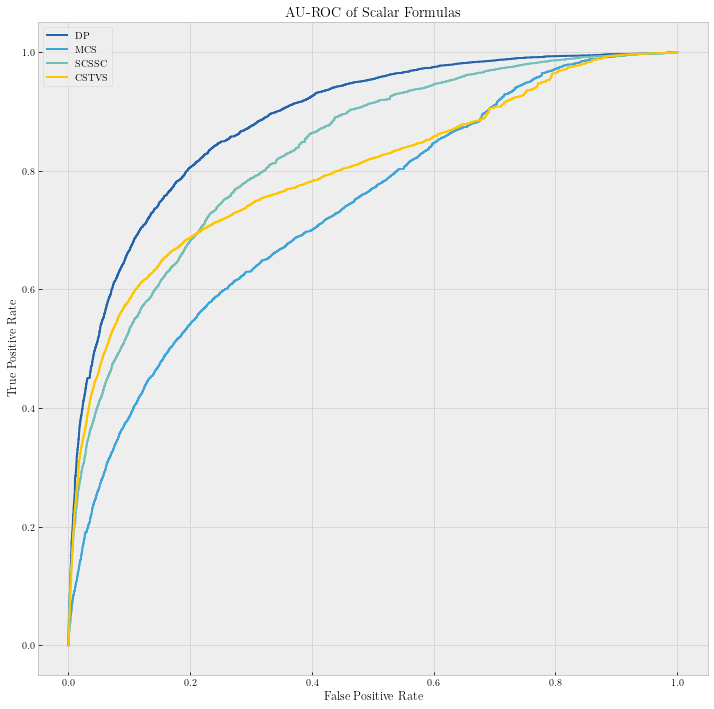

In [85]:
color_list = {'dp':"#2364AA",'mcs':"#3DA5D9",'scssc':"#73BFB8",'cstvs':"#FEC601",'mid':"#EA7317"}
line_list = {'d':":",'o':"-"}
fig_roc_s = plt.figure(figsize=(12,12),facecolor='w')
for i in ['dp','mcs','scssc','cstvs']:
#     for j in ['d','o']:
    for j in ['o']:   
        fpr, tpr, thresholds = roc_curve(tweet_encoded['irma_rel'],tweet_encoded[f'MM-{j}-sw-{i}'])
        label_text = i.upper()
#         label_text = i.upper()+"("+j.upper()+")"
        plt.plot(fpr,tpr,label=label_text,linestyle=line_list.get(j),color=color_list.get(i))
# plt.plot([0,1],[0,1],linestyle="-.",label=".5 Threshold",color=color_list.get('mid'))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AU-ROC of Scalar Formulas")
plt.legend()
plt.show()
#fig_roc_s.savefig(f'./figures/scalar_roc_art_curve.pdf',bbox_inches='tight')

In [86]:
tweet_times = tweet_encoded.set_index('timestamp')

In [87]:
tweet_times['oSWDPStd'] = (tweet_times['o-sw-dp'] - tweet_times['o-sw-dp'].mean())/tweet_times['o-sw-dp'].std()

In [88]:
tweet_times['oSWDPStdMM'] = ((tweet_times['oSWDPStd'] - tweet_times['oSWDPStd'].min())* 100) / (tweet_times['oSWDPStd'].max() - tweet_times['oSWDPStd'].min())

In [89]:
tweet_times['MMoDPNormStd']  = (tweet_times['MM-o-sw-dp'] - tweet_times['MM-o-sw-dp'].mean())/tweet_times['MM-o-sw-dp'].std()

In [90]:
np.all(tweet_times['oSWDPStdMM'] == tweet_times['MM-o-sw-dp'])

False

In [91]:
tweet_times[tweet_times['oSWDPStdMM'] != tweet_times['MM-o-sw-dp']]

,index,irma_rel,tweet,tweet_id,tweet_text,user_id,tweet_coords,tweet_coords_list,tweet_long,tweet_lat,...,MM-o-sw-dp,o-sw-mcs,MM-o-sw-mcs,o-sw-scssc,MM-o-sw-scssc,o-sw-cstvs,MM-o-sw-cstvs,oSWDPStd,oSWDPStdMM,MMoDPNormStd
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-09-10 00:00:01,0,1,"Wind 2.0 mph N. Barometer 29.880 in, Steady. Temperature 79.1 F. Rain today 0.95 in. Humidity 84",906668545542680576,"Wind 2.0 mph N. Barometer 29.880 in, Steady. Temperature 79.1 F. Rain today 0.95 in. Humidity 84",1227982520,"[28.87527778,-81.2525]","[[[-81.285896, 28.84511], [-81.285896, 28.964071], [-81.154121, 28.964071], [-81.154121, 28.84511]]]",-81.2525,28.8753,...,34.432837,0.100242,25.492836,0.316994,33.085853,0.138424,29.245034,0.724131,34.432837,0.724131
2017-09-10 00:00:03,1,0,"There is always beauty regardless the circumstance @ Palm Coast, Florida https://t.co/yiBci8e474",906668555185291265,"There is always beauty regardless the circumstance @ Palm Coast, Florida https://t.co/yiBci8e474",42239064,"[29.5381,-81.2234]","[[[-81.279617, 29.424649], [-81.279617, 29.627243], [-81.158741, 29.627243], [-81.158741, 29.424649]]]",-81.2234,29.5381,...,27.037855,0.155455,30.064849,0.411294,38.221773,0.322350,44.349531,0.187098,27.037855,0.187098
2017-09-10 00:00:03,2,0,#Carpool #Orlando - gt #Orlando #KIrkmanRoad rideshare split costs take turns https://t.co/J6oThuqvwG,906668556493889536,#Carpool #Orlando - gt #Orlando #KIrkmanRoad rideshare split costs take turns https://t.co/J6oThuqvwG,87188071,"[28.4363045,-81.4797168]","[[[-87.634643, 24.396308], [-87.634643, 31.001056], [-79.974307, 31.001056], [-79.974307, 24.396308]]]",-81.4797,28.4363,...,20.601817,0.122264,27.316403,0.366792,35.798022,0.325801,44.632953,-0.280295,20.601817,-0.280295
2017-09-10 00:00:06,3,0,@avictoria_x nah i m chillin my eyes never get red,906668570079309830,@avictoria_x nah i m chillin my eyes never get red,746764728,NaN,"[[[-81.25235, 28.549308], [-81.25235, 28.582242], [-81.22368, 28.582242], [-81.22368, 28.549308]]]",-81.2380,28.5658,...,22.881952,0.198729,33.648309,0.486784,42.333250,0.379647,49.054937,-0.114708,22.881952,-0.114708
2017-09-10 00:00:08,4,0,@jvnvy @sza That s how I feel bout seein travis,906668576056246278,@jvnvy @sza That s how I feel bout seein travis,1679199278,NaN,"[[[-82.31457, 27.823335], [-82.31457, 27.853744], [-82.260881, 27.853744], [-82.260881, 27.823335]]]",-82.2877,27.8385,...,11.546928,0.089933,24.639167,0.179867,25.617379,0.207291,34.900571,-0.937872,11.546928,-0.937872
2017-09-10 00:00:10,5,1,Taking a beak from boarding the windows. Kitty pettin. @ https://t.co/g6C1zUbjc5,906668586793660416,Taking a beak from boarding the windows. Kitty pettin. @ https://t.co/g6C1zUbjc5,33160615,"[27.91,-82.35]","[[[-87.634643, 24.396308], [-87.634643, 31.001056], [-79.974307, 31.001056], [-79.974307, 24.396308]]]",-82.3500,27.9100,...,17.095729,0.150683,29.669741,0.369097,35.923559,0.314694,43.720835,-0.534911,17.095729,-0.534911
2017-09-10 00:00:11,6,1,"19:53 Temp. 82.4 F, Hum. 79 , Dewp. 73.6 F, Bar. 1007 hpa, Rain Today 0.0517 inch, Wind 142 3.2 kn",906668589385764864,"19:53 Temp. 82.4 F, Hum. 79 , Dewp. 73.6 F, Bar. 1007 hpa, Rain Today 0.0517 inch, Wind 142 3.2 kn",19511251,"[27.86977674,-82.80524377]","[[[-82.81611, 27.80979], [-82.81611, 27.884351], [-82.752081, 27.884351], [-82.752081, 27.80979]]]",-82.8052,27.8698,...,30.229162,0.080743,23.878165,0.279703,31.054854,0.112890,27.148113,0.418855,30.229162,0.418855
2017-09-10 00:00:11,7,1,"I m so proud of our local radio, news, animal shelters, people there s some bad but there is SO. Much. Good. #IrmaHurricane2017",906668590878871555,"I m so proud of our local radio, news, animal shelters, people there s some bad but there is SO. Much. Good. #IrmaHurricane2017",328572345,NaN,"[[[-82.771167, 27.839081], [-82.771167, 27.878053], [-82.73758, 27.878053], [-82.73758, 27.839081]]]",-82.7544,27.8586,...,30.643676,0.166963,31.017830,0.553753,45.980626,0.287891,41.519702,0.448958,30.643676,0.448958
2017-09-10 

In [92]:
tweet_times[['oSWDPStd','oSWDPStdMM','MMoDPNormStd','MM-o-sw-dp']].head()

,oSWDPStd,oSWDPStdMM,MMoDPNormStd,MM-o-sw-dp
timestamp,,,,
2017-09-10 00:00:01,0.724131,34.432837,0.724131,34.432837
2017-09-10 00:00:03,0.187098,27.037855,0.187098,27.037855
2017-09-10 00:00:03,-0.280295,20.601817,-0.280295,20.601817
2017-09-10 00:00:06,-0.114708,22.881952,-0.114708,22.881952
2017-09-10 00:00:08,-0.937872,11.546928,-0.937872,11.546928


In [93]:
tweet_times.groupby(tweet_times.index.hour).count()['tweet']

timestamp
0     1246
1     1086
2     967 
3     898 
4     657 
5     435 
6     325 
7     248 
8     201 
9     238 
10    316 
11    515 
12    612 
13    883 
14    912 
15    1059
16    1105
17    1194
18    1040
19    1019
20    1075
21    933 
22    988 
23    1136
Name: tweet, dtype: int64

In [94]:
tweet_times['oSWDPStd'].std()

1.0000000000000002

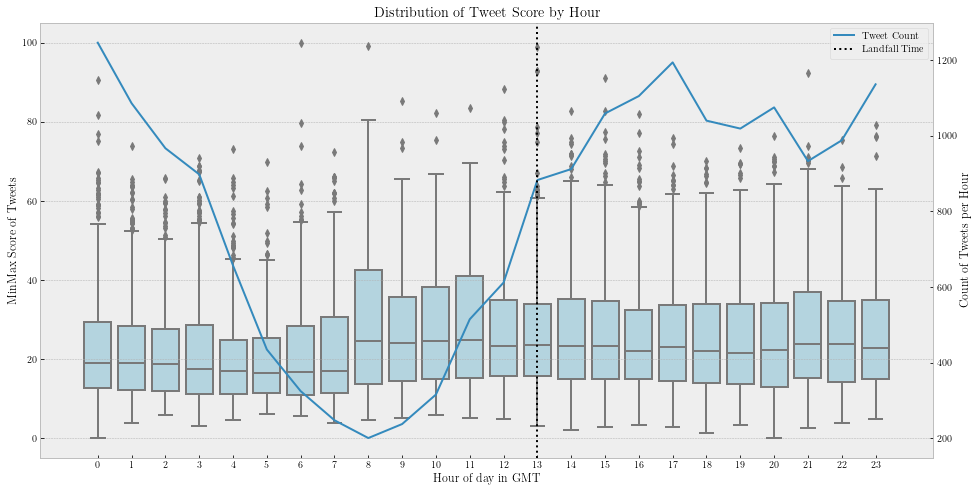

In [95]:
import seaborn as sns
fig = plt.figure(figsize=(16,8))

ax1 = fig.add_subplot()


# sns.stripplot(x=tweet_times.index.hour,y=tweet_times['MMoDPNormStd'],jitter=.35,palette='viridis',alpha=.5)
sns.boxplot(x=tweet_times.index.hour,y=tweet_times['oSWDPStdMM'],color='lightblue')

ax1.set_xlabel('Hour of day in GMT')
ax1.set_ylabel('MinMax Score of Tweets')
ax1.set_title('Distribution of Tweet Score by Hour')
ax2 = ax1.twinx()
ax2.plot(tweet_times.groupby(tweet_times.index.hour).count()['tweet'],label='Tweet Count')
ax2.set_ylabel('Count of Tweets per Hour')
ax2.axvline(x=13,label='Landfall Time',linestyle=':',color='black')
ax2.grid(b=False)
ax2.legend()
plt.show()
fig.savefig(f'./figures/boxplot.pdf',bbox_inches='tight')

In [96]:
tweet_times.index.hour

Int64Index([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
            ...
            23, 23, 23, 23, 23, 23, 23, 23, 23, 23],
           dtype='int64', name='timestamp', length=19088)

## Optimized Loops

In [97]:
[10,25,50,100,125,250,500]

[10, 25, 50, 100, 125, 250, 500]

In [98]:
# tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
# tweets_tokens = tweet_text.apply(tokens_no_stopwords)
# coded_tweets = pd.read_csv(r'./irma_related_tweets.csv')
# tweets_on_date = tweet_full_en.loc[tweet_date:tweet_date+date_delta]
# tweet_encoded = pd.concat([coded_tweets.reset_index(),tweets_on_date.iloc[:-1].reset_index()],axis=1)
# search_term = 'irma'
# # Hidden Layer Dimensions (hld)
# # Minimum Word Count (mwc)
# # Word Window Size (wws)
# # Negative Sampling (ns)
# # Epochs (ep)
# # Scoring formulas (sf)

In [99]:
# roc_df = pd.DataFrame()
# for hld in range(50,501,50):
#     for mwc in range(10):
#         for wws in range(1,11):
#             for ns in range(10):
#                 for ep in [10,25,50,100,125,250,500]:
#                     vector_model = Word2Vec(tweets_tokens, seed=1, sg=1, workers=1,
#                                             size = hld,
#                                             min_count = mwc,
#                                             window = wws,
#                                             negative = ns)
#                     vector_model.train(tweets_tokens,
#                                        total_examples = len(tweet_text),
#                                        epochs=ep)
#                     for sf in ['dp','mcs','scssc','cstvs']:
# #                         score tweets
#                         tweet_encoded['score'] = tweet_encoded.tweet_text.apply(scalarFunctions,args=(vector_model,sf))
# #                         convert to min-max
#                         tweet_scores = tweet_encoded['score']
#                         tweet_encoded['mm'] = ((tweet_scores - tweet_scores.min())* 100) / (tweet_scores.max() - tweet_scores.min())
# #                         get AU-ROC
#                         roc_row_score = roc_auc_score(tweet_encoded['irma_rel'],tweet_encoded['mm'])
# #                         add to DataFrame
#                         roc_row = pd.DataFrame([roc_row_score,hld,mwc,wwc,ns,ep,sf]).T
#                         roc_df = roc_df.append(roc_row, ignore_index=True)
# #                         roc_df = pd.concat([roc_df,roc_row.T],axis=0)
#                         roc_row

In [100]:
# roc_df.to_csv('./optimal.csv')

In [101]:
# roc_df.rename(columns={0:'AUROC',1:'HLD',2:'MWC',3:'WWS',4:'NS',5:'EP',6:'SF'}).sort_values('AUROC',ascending=False)

In [102]:
# roc_df.loc[14032]

NameError: name 'roc_df' is not defined

In [ ]:
for i in ['dp','mcs','scssc','cstvs']:
#     print(round(roc_auc_score(tweet_encoded['irma_rel'],tweet_encoded[f'MM_sw_{i}']),4))

### Saed's tweets:

In [ ]:
# s_tweets = pd.read_csv(r'./irma_3days_tweets.csv')

In [ ]:
# s_tweets.head(5)

In [ ]:
# s_tweets_tokens = s_tweets['text'].apply(tokens_no_stopwords)
# s_tweets_v_model = Word2Vec(s_tweets_tokens,
#                            min_count=MWC,
#                            window = WWS,
#                            workers=1,
#                            size=HD,
#                            seed=1,
#                            sg=1,
#                            negative = NS)
# s_tweets_v_model.train(s_tweets_tokens, total_examples = len(s_tweets['text']), epochs=EP)

In [ ]:
# s_tweets['dp_score'] = s_tweets['text'].apply(scalarFunctions,args=(opt_vector_model,'dp'))
# s_tweets_scores = s_tweets['dp_score']
# s_tweets['mm_dp_score'] = ((s_tweets_scores - s_tweets_scores.min())* 100) / (s_tweets_scores.max() - s_tweets_scores.min())

In [ ]:
# s_tweets.to_csv(r'./irma_3days_tweets_scored.csv')

In [ ]:
# s_tweets.sort_values('mm_dp_score',ascending=False)

### Related Words by 1 Hour Increments

In [ ]:
related_words = pd.DataFrame()
tweet_date = pd.to_datetime("2017-09-10 00:00:00")
date_delta = pd.Timedelta("1HR")
end_date = pd.to_datetime("2017-09-11 00:00:00")
top_num_words = 20
search_term = 'irma'

In [ ]:
for tweet_day in pd.date_range(start = tweet_date, end = end_date, freq = date_delta):
    tweet_text = tweet_full_en.loc[tweet_day:tweet_day + date_delta,"tweet_text"]
    tweets_tokens = tweet_text.apply(tokens_no_stopwords)
    opt_vector_model_1hr = Word2Vec(tweets_tokens, min_count=MWC, window=WWS, workers=1, size=HD, seed=1, sg=1, negative=NS)
    opt_vector_model_1hr.train(tweets_tokens, total_examples=len(tweet_text), epochs=EP)
    opt_word_matrix_1hr = opt_vector_model_1hr.wv[opt_vector_model_1hr.wv.vocab]
    terms_from_range = pd.DataFrame.from_records(opt_vector_model_1hr.wv.most_similar(search_term,topn=top_num_words),columns=[tweet_day,"Cos_Sim"])
    related_words = pd.concat([related_words,terms_from_range],axis=1)

In [ ]:
# related_words.iloc[:,0::2].to_csv(r'./190928_words.csv')

In [ ]:
# related_words.to_csv('./top_words_no_scores.csv')

### Network Graphs

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
# t_vect = TfidfVectorizer(
#     tokenizer=lambda x: x,
#     preprocessor=lambda x: x)

In [ ]:
# t_vect_vectors = t_vect.fit_transform(tweets_tokens)

In [ ]:
# pd.DataFrame(t_vect.idf_, index=t_vect.get_feature_names(),columns=["idf_weights"])

In [ ]:
# token_counts = tweets_tokens.apply(pd.Series).stack().value_counts()

In [ ]:
# len(t_vect.vocabulary_) == len(token_counts)

In [ ]:
# len(t_vect.idf_)

In [ ]:
# t_vect.idf_

In [ ]:
# len(t_vect.get_feature_names())

In [ ]:
# pd.DataFrame(t_vect_vectors.todense(),columns=t_vect.vocabulary_)

In [ ]:
# t_vect.get_feature_names()

In [ ]:
# t_vect.vocabulary_.get('zure')

In [ ]:
# cos(pi/4)

In [ ]:
# from itertools import combinations
# word_pairs = list(combinations(list(vector_model.wv.vocab.keys()),2))
# tweet_graph = nx.Graph()
# for word_count in token_counts.iteritems():
#     tweet_graph.add_node(word_count[0],count=word_count[1])
# for pair in word_pairs:
#     edge_weight = vector_model.wv.similarity(pair[0],pair[1])
#     if edge_weight > .80:
#         tweet_graph.add_edge(pair[0],pair[1],weight=edge_weight)
# nx.write_gexf(tweet_graph,path=r'./tweet_graph.gexf')

In [ ]:
# from itertools import combinations
# word_pairs = list(combinations(list(opt_vector_model.wv.vocab.keys()),2))
# tweet_graph = nx.Graph()
# for word_count in range(len(t_vect.idf_)):
#     tweet_graph.add_node(t_vect.get_feature_names()[word_count],tfidf=t_vect.idf_[word_count])
# for pair in word_pairs:
#     edge_weight = opt_vector_model.wv.similarity(pair[0],pair[1])
#     if edge_weight > cos(pi/4):
#         tweet_graph.add_edge(pair[0],pair[1],weight=edge_weight)
# nx.write_gexf(tweet_graph,path=r'./tweet_graph_idf_cos.gexf')

In [ ]:
# num_words = 10
# tweet_graph = nx.Graph()
# # for word_count in token_counts.iteritems():
# # for word_count in t_vect.vocabulary_.items():
# #     tweet_graph.add_node(word_count[0],count=word_count[1])
# for word_count in range(len(t_vect.idf_)):
# #     tweet_graph.add_node(word_count[0],tfidf=word_count[1])
#     tweet_graph.add_node(t_vect.get_feature_names()[word_count],tfidf=t_vect.idf_[word_count])
# for word in list(opt_vector_model.wv.vocab.keys()):
#     word_scores = opt_vector_model.wv.most_similar(word, topn=num_words)
#     for i in range(num_words):
#         tweet_graph.add_edge(word,word_scores[i][0],weight=word_scores[i][1])
# nx.write_gexf(tweet_graph,path=f'./tweet_graph_{num_words}_tfidf.gexf')

In [ ]:
for i in range(1,11):
#     create strings for column heads
    sw = f'score_window_{i}'
    mmsw = f'MM_{sw}'
    
#     Scoring tweets in this column:
    tweet_encoded[sw] = tweet_encoded.tweet_text.apply(scalarFunctions,args=(vectors_series.iloc[i],'scssc'))
                                                       
#     column of scores for this iteration
    tweet_scores = tweet_encoded[sw]

#     calculating Min Max Scaling for this column 
    tweet_encoded[mmsw] = ((tweet_scores - tweet_scores.min())* 100) / (tweet_scores.max() - tweet_scores.min())

In [ ]:
for i in range(1,11):
    print(round(roc_auc_score(tweet_encoded['irma_rel'],tweet_encoded[f'MM_score_window_{i}']),3))

In [ ]:
coded_tweets = pd.read_csv(r'./irma_related_tweets.csv')

tweets_on_date = tweet_full_en.loc[tweet_date:tweet_date+date_delta]

tweet_encoded = pd.concat([coded_tweets.reset_index(),tweets_on_date.iloc[:-1].reset_index()],axis=1)

In [ ]:
for i in range(1,11):
#     create strings for column heads
    sw = f'score_window_{i}'
    mmsw = f'MM_{sw}'
    
#     Scoring tweets in this column:
    tweet_encoded[sw] = tweet_encoded.tweet_text.apply(ScoreTweetFromVectors,args=(vectors_series.iloc[i],))
                                                       
#     column of scores for this iteration
    tweet_scores = tweet_encoded[sw]

#     calculating Min Max Scaling for this column 
    tweet_encoded[mmsw] = ((tweet_scores - tweet_scores.min())* 100) / (tweet_scores.max() - tweet_scores.min())

In [ ]:
fig_hld_1 = plt.figure(figsize=(16,8),facecolor='w')

for j in range(1,11):
    window_label = f"{comparison_type}: {25*j + 25}"
    plt.plot(range(101),[len(tweet_encoded[tweet_encoded[f'MM_score_window_{j}'] > i])/len(tweet_encoded) for i in range(101)],label=window_label)
plt.xlabel("Min-Max Scaled Tweet Score Threshold")
plt.ylabel("Percent of Tweets at or Above Threshold")
plt.title(f"Percent of Tweets at or Above Threshold by Word2Vec {comparison_type} ({func_type})")
plt.legend();

# fig_hld_1.savefig(f'./figures/{comparison_short}{func_short}PercentTweetsBelow.pdf',bbox_inches='tight')

### F1 Score Comparisons

In [134]:
tweet_encoded.columns

Index(['index', 'irma_rel', 'tweet', 'timestamp', 'tweet_id', 'tweet_text',
       'user_id', 'tweet_coords', 'tweet_coords_list', 'tweet_long',
       'tweet_lat', 'location', 'enc_url', 'tweet_lang', 'hashtags', 'd-sw-dp',
       'MM-d-sw-dp', 'd-sw-mcs', 'MM-d-sw-mcs', 'd-sw-scssc', 'MM-d-sw-scssc',
       'd-sw-cstvs', 'MM-d-sw-cstvs', 'o-sw-dp', 'MM-o-sw-dp', 'o-sw-mcs',
       'MM-o-sw-mcs', 'o-sw-scssc', 'MM-o-sw-scssc', 'o-sw-cstvs',
       'MM-o-sw-cstvs'],
      dtype='object')

In [143]:
# f1_window_score_df = pd.DataFrame(np.zeros((101,11)))
# pre_score_df = pd.DataFrame(np.zeros((101,11)))
# rec_score_df = pd.DataFrame(np.zeros((101,11)))
f1_window_score_df = pd.DataFrame(np.zeros((101,)))
pre_score_df = pd.DataFrame(np.zeros((101,)))
rec_score_df = pd.DataFrame(np.zeros((101,)))

In [144]:
# for i in range(1,11):
#     for j in range(101):
#         f1_window_score_df.iloc[j,i] = f1_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)
#         pre_score_df.iloc[j,i] = precision_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)
#         rec_score_df.iloc[j,i] = recall_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)
for j in range(101):
    f1_window_score_df.iloc[j] = f1_score(tweet_encoded.irma_rel,tweet_encoded['MM-o-sw-cstvs'] > j)
    pre_score_df.iloc[j] = precision_score(tweet_encoded.irma_rel,tweet_encoded['MM-o-sw-cstvs'] > j)
    rec_score_df.iloc[j] = recall_score(tweet_encoded.irma_rel,tweet_encoded['MM-o-sw-cstvs'] > j)

In [145]:
f1_window_score_df.idxmax()[0]

45

In [146]:
print(pd.concat([f1_window_score_df.idxmax(),f1_window_score_df.max()],axis=1,names=['TweetScore','F1Score']))
# print('Index of max F1 score:')
# print(f1_window_score_df.idxmax())
print('max F1 score:')
max_idx = f1_window_score_df.idxmax()[0]
print(f1_window_score_df.iloc[max_idx][0])
print('Precision at max F1 score:')
print(pre_score_df.iloc[max_idx][0])
print('Recall at max F1 score:')
print(rec_score_df.iloc[max_idx][0])


    0         1
0  45  0.704994
max F1 score:
0.7049943389105547
Precision at max F1 score:
0.7371744277821626
Recall at max F1 score:
0.6755062680810029


In [108]:
print(f1_window_score_df.idxmax().max())

21


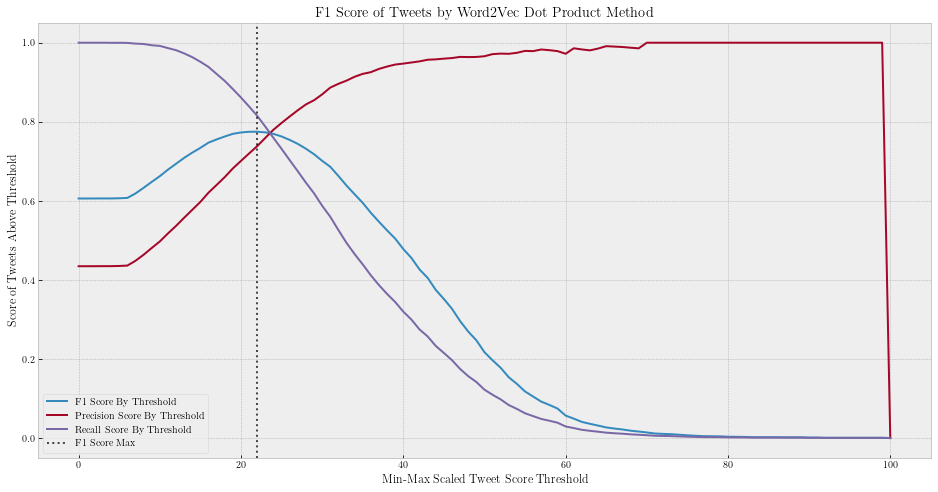

In [125]:
fig_hld_2 = plt.figure(figsize=(16,8),facecolor='w')
# for i in range(1,11):
#     window_label = f"{comparison_type}: {25*i + 25}"
#     plt.plot(f1_window_score_df.iloc[:,i],label=window_label)
plt.plot(f1_window_score_df,label="F1 Score By Threshold")
plt.plot(pre_score_df,label="Precision Score By Threshold")
plt.plot(rec_score_df,label="Recall Score By Threshold")
plt.xlabel("Min-Max Scaled Tweet Score Threshold")
plt.ylabel("Score of Tweets Above Threshold")
plt.axvline(f1_window_score_df.idxmax().max(),linestyle=":",color="black",alpha=.7,label="F1 Score Max")
# plt.title(f"F1 Score of Tweets by Word2Vec {comparison_type} ({func_type})")
plt.title(f"F1 Score of Tweets by Word2Vec Dot Product Method")
plt.legend();
fig_hld_2.savefig(f'./figures/DP_F1Score.pdf',bbox_inches='tight')

### Negative Sampling (window size 7, dim = 100)

In [ ]:
comparison_type = "Negative Sampling Test"
comparison_short = "NS"

In [ ]:
# eliminating the off-by-one error in the loop later. This will have a zero row, unfilled by vectors.
vectors_series = pd.Series(np.zeros((11)))

In [ ]:
tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
tweets_tokens = tweet_text.apply(tokens_no_stopwords)
for i in range(0,11):
    ns_size = i
    # ---------- Skip-Gram ----------
    # initialize the Word2Vec vectors with window size 7, min count 1, and Skip-Gram (Negative Sampling Test)
    vector_model = Word2Vec(tweets_tokens, min_count=1, window=7, workers=1, size=100, seed=1, sg=1, negative=ns_size)
    
    # train the model over 10 epochs
    vector_model.train(tweets_tokens, total_examples=len(tweet_text), epochs=10)
    
    # assign the vector data to its position in a series
    vectors_series.iloc[i] = vector_model

In [ ]:
coded_tweets = pd.read_csv(r'./irma_related_tweets.csv')

tweets_on_date = tweet_full_en.loc[tweet_date:tweet_date+date_delta]

tweet_encoded = pd.concat([coded_tweets.reset_index(),tweets_on_date.iloc[:-1].reset_index()],axis=1)

In [ ]:
vectors_series

In [ ]:
for i in range(0,11):
#     create strings for column heads
    sw = f'score_window_{i}'
    mmsw = f'MM_{sw}'
    
#     Scoring tweets in this column:
    tweet_encoded[sw] = tweet_encoded.tweet_text.apply(ScoreTweetFromVectors,args=(vectors_series.iloc[i],))
                                                       
#     column of scores for this iteration
    tweet_scores = tweet_encoded[sw]

#     calculating Min Max Scaling for this column 
    tweet_encoded[mmsw] = ((tweet_scores - tweet_scores.min())* 100) / (tweet_scores.max() - tweet_scores.min())

In [ ]:
fig_roc_1 = plt.figure(figsize=(12,12),facecolor='w')
for i in range(1,2):
    fpr, tpr, thresholds = roc_curve(tweet_encoded['irma_rel'],tweet_encoded[f'MM_score_window_{i}'])
    plt.plot(fpr,tpr,label=f"Negative Sample Test: {i}")
plt.plot([0,1],[0,1],linestyle="-.",label=".5 Threshold")
plt.legend()
plt.show()
# fig_roc_1.savefig(f'./figures/neg_samp_size_1-10_roc_curve.pdf',bbox_inches='tight')

In [ ]:
fig_ns_1 = plt.figure(figsize=(16,8),facecolor='w')

for j in range(0,11):
    window_label = f"{comparison_type}: {j}"
    plt.plot(range(101),[100 * len(tweet_encoded[tweet_encoded[f'MM_score_window_{j}'] > i])/len(tweet_encoded) for i in range(101)],label=window_label)
plt.xlabel("Min-Max Scaled Tweet Score Threshold")
plt.ylabel("Percent of Tweets Above Threshold")
plt.title(f"Percent of Tweets Above Threshold by Word2Vec {comparison_type} ({func_type})")
plt.legend();

#fig_ns_1.savefig(f'./figures/{comparison_short}{func_short}PercentTweetsBelow.pdf',bbox_inches='tight')

In [ ]:
from scipy.stats import norm
print(np.linspace(1,100,100))
#norm.cdf(tweet_encoded['MM_score_window_1'],np.linspace(1,100,100))

In [ ]:
plt.hist(tweet_encoded['MM_score_window_1'].values,bins=100)

### F1 Score Comparisons

In [ ]:
f1_window_score_df = pd.DataFrame(np.zeros((101,11)))
pre_score_df = pd.DataFrame(np.zeros((101,11)))
rec_score_df = pd.DataFrame(np.zeros((101,11)))

In [ ]:
for i in range(0,11):
    for j in range(101):
        f1_window_score_df.iloc[j,i] = f1_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)
        pre_score_df.iloc[j,i] = precision_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)
        rec_score_df.iloc[j,i] = recall_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)

In [ ]:
ns_test = pd.DataFrame(pd.concat([f1_window_score_df.idxmax().rename('MM_Score'),f1_window_score_df.max().rename('F1_Score_Max')],axis=1))
ns_test['Neg_Samp_Size'] = pd.Series(range(0,11))

In [ ]:
ns_test[['Neg_Samp_Size','MM_Score','F1_Score_Max']]

In [ ]:
print(f1_window_score_df.idxmax().max())
print(f1_window_score_df.max().idxmax())

In [ ]:
fig_ns_2 = plt.figure(figsize=(16,8),facecolor='w')
for i in range(0,11):
    if i == f1_window_score_df.max().idxmax():
        plt.plot(f1_window_score_df.iloc[:,i],label=f"{comparison_type}: {i} (F1 Max)",linestyle=":")
    else:
        plt.plot(f1_window_score_df.iloc[:,i],label=f"{comparison_type}: {i}")
plt.xlabel("Min-Max Scaled Tweet Score Threshold")
plt.ylabel("F1 Score of Tweets Above Threshold")
plt.title(f"F1 Score of Tweets by Word2Vec {comparison_type} ({func_type})")
plt.legend();
# fig_ns_2.savefig(f'./figures/neg_samp_size_1-10_F1Score.pdf',bbox_inches='tight')

In [ ]:
tweet_to_score = tweet_full[tweet_full.tweet_text.str.contains('will post again')].tweet_text[0]

ScoreTweetFromVectors(tweet_to_score,vector_set=vectors_series.iloc[1])
# print(type(tweet_to_score))
# print(tweet_to_score)

In [ ]:
print(tweet_to_score)

In [ ]:
tweet_encoded[(tweet_encoded['score_window_1'] > 22.85) & (tweet_encoded['score_window_1'] < 22.88)]['MM_score_window_1']

In [ ]:
roc_auc_score(tweet_encoded['irma_rel'],tweet_encoded['MM_score_window_1'])

In [ ]:
fpr, tpr, thresholds = roc_curve(tweet_encoded['irma_rel'],tweet_encoded['MM_score_window_1'])

In [ ]:
fig_roc_1 = plt.figure(figsize=(12,12),facecolor='w')
plt.plot(fpr,tpr,label='Score of Text Module')
plt.plot([0,1],[0,1],label='.5 AUROC Threshold')
plt.legend()
plt.show()
# fig_roc_1.savefig(f'./figures/text_mod_roc_curve.pdf',bbox_inches='tight')

In [ ]:
fig_roc_1 = plt.figure(figsize=(12,12),facecolor='w')
for i in range(1,2):
    fpr, tpr, thresholds = roc_curve(tweet_encoded['irma_rel'],tweet_encoded[f'MM_score_window_{i}'])
    plt.plot(fpr,tpr,label=f"Negative Sample Test: {i}")
plt.plot([0,1],[0,1],linestyle="-.",label=".5 Threshold")
plt.legend()
plt.show()
# fig_roc_1.savefig(f'./figures/neg_samp_size_1-10_roc_curve.pdf',bbox_inches='tight')